In [2]:
import pandas as pd

tsla_options = pd.read_csv('tsla_options.csv', parse_dates=[0, 1])
tsla_options.head()

,Date,ExpiryDate,Symbol,UnderlyingSymbol,OSISymbol,CallPut,Strike,Volume,OpenInterest,Bid,Ask,Last
0,2019-10-14,2019-10-18,TSLA9JIC450000,TSLA,TSLA191018C00450000,Call,450.0,0.0,146.0,0.00,0.02,0.02
1,2019-10-14,2019-10-18,TSLA9JIC445000,TSLA,TSLA191018C00445000,Call,445.0,0.0,0.0,0.00,0.03,0.00
2,2019-10-14,2019-10-18,TSLA9JIC440000,TSLA,TSLA191018C00440000,Call,440.0,0.0,4.0,0.00,0.03,0.02
3,2019-10-14,2019-10-18,TSLA9JIC435000,TSLA,TSLA191018C00435000,Call,435.0,0.0,13.0,0.00,0.03,0.02
4,2019-10-14,2019-10-18,TSLA9JIC430000,TSLA,TSLA191018C00430000,Call,430.0,2.0,26.0,0.01,0.02,0.01


In [4]:
tsla_prices = pd.read_csv('tsla_prices.csv', parse_dates=[0])
tsla_prices.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-14,342.380005,342.500000,334.000000,334.399994,334.399994,5247300
1,2019-01-15,335.000000,348.799988,334.500000,344.429993,344.429993,6056600
2,2019-01-16,344.779999,352.000000,343.500000,346.049988,346.049988,4691700
3,2019-01-17,346.209991,351.500000,344.149994,347.309998,347.309998,3676700
4,2019-01-18,323.000000,327.130005,299.730011,302.260010,302.260010,24150800


In [11]:
merged = tsla_options.merge(tsla_prices[['Date', 'Close']], how='left', on='Date')
merged.loc[:, 'DTE'] = (merged.ExpiryDate - merged.Date).dt.days
merged.head()

,Date,ExpiryDate,Symbol,UnderlyingSymbol,OSISymbol,CallPut,Strike,Volume,OpenInterest,Bid,Ask,Last,Close,DTE
0,2019-10-14,2019-10-18,TSLA9JIC450000,TSLA,TSLA191018C00450000,Call,450.0,0.0,146.0,0.00,0.02,0.02,256.959991,4
1,2019-10-14,2019-10-18,TSLA9JIC445000,TSLA,TSLA191018C00445000,Call,445.0,0.0,0.0,0.00,0.03,0.00,256.959991,4
2,2019-10-14,2019-10-18,TSLA9JIC440000,TSLA,TSLA191018C00440000,Call,440.0,0.0,4.0,0.00,0.03,0.02,256.959991,4
3,2019-10-14,2019-10-18,TSLA9JIC435000,TSLA,TSLA191018C00435000,Call,435.0,0.0,13.0,0.00,0.03,0.02,256.959991,4
4,2019-10-14,2019-10-18,TSLA9JIC430000,TSLA,TSLA191018C00430000,Call,430.0,2.0,26.0,0.01,0.02,0.01,256.959991,4


In [26]:
from py_vollib.black_scholes.greeks.analytical import delta
from py_vollib.black_scholes.implied_volatility import implied_volatility

hardcoded_interest_rate = 0.015

def calc_greeks(row_of_data):
    try:
        iv = implied_volatility((row_of_data.Bid+row_of_data.Ask)/2, row_of_data.Close, row_of_data.Strike,
                                row_of_data.DTE/365, hardcoded_interest_rate, 'c' if row_of_data.CallPut == 'Call' else 'p')
        calc_del = delta('c' if row_of_data.CallPut == 'Call' else 'p', row_of_data.Close, row_of_data.Strike,
                         row_of_data.DTE/365, hardcoded_interest_rate, iv)
    except Exception as e:
#         print(e)
        return None, None
    return iv, calc_del

# merged[['impl_vol', 'delta']] = merged.apply(calc_greeks, axis=1).apply(pd.Series)

In [11]:
merged.to_csv('tsla_options_price_greeks.csv', index=False)

In [1]:
import pandas as pd

merged = pd.read_csv('tsla_options_price_greeks_combined.csv', parse_dates=[0, 1])
merged.head()

,Date,ExpiryDate,Symbol,UnderlyingSymbol,OSISymbol,CallPut,Strike,Volume,OpenInterest,Bid,Ask,Last,Close,DTE,impl_vol,delta
0,2018-12-25,2018-12-28,TSLAL28183165000,TSLA,TSLA181228C00165000,Call,165.0,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN
1,2018-12-25,2018-12-28,TSLAL28183170000,TSLA,TSLA181228C00170000,Call,170.0,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN
2,2018-12-25,2018-12-28,TSLAL28183175000,TSLA,TSLA181228C00175000,Call,175.0,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN
3,2018-12-25,2018-12-28,TSLAL28183180000,TSLA,TSLA181228C00180000,Call,180.0,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN
4,2018-12-25,2018-12-28,TSLAL28183185000,TSLA,TSLA181228C00185000,Call,185.0,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN


In [2]:
merged = merged.dropna(subset=['delta'])
merged['delta_buckets'] = pd.cut(merged.delta, bins=40)

merged['delta_buckets_left'] = merged.delta_buckets.apply(lambda x: x.left)

In [4]:
from scipy.stats import percentileofscore

merged['iv_perc'] = merged.groupby('delta_buckets').apply(lambda x: x.sort_values('Date')['impl_vol'].rolling(252).apply(lambda y: percentileofscore(y, y[-1]), raw=True)).reset_index(level=0).drop('delta_buckets', axis=1)
merged['iv_rank'] = merged.groupby('delta_buckets').apply(lambda x: x.sort_values('Date')['impl_vol'].rolling(252).apply(lambda y: (y[-1] - y.min()) / (y.max() - y.min()), raw=True)).reset_index(level=0).drop('delta_buckets', axis=1)

In [5]:
for_charting = merged.groupby(['Date', 'delta_buckets_left'])['iv_perc'].mean().reset_index()
for_charting.head()

,Date,delta_buckets_left,iv_perc
0,2018-12-26,-1.002,50.150804
1,2018-12-26,-0.950,50.388506
2,2018-12-26,-0.900,51.353362
3,2018-12-26,-0.850,47.414966
4,2018-12-26,-0.800,50.481000


In [6]:
for_charting_1 = for_charting.pivot(index='Date', columns='delta_buckets_left', values='iv_perc')
for_charting_1.head()

delta_buckets_left,-1.002,-0.95,-0.9,-0.85,-0.8,-0.75,-0.7,-0.65,-0.6,-0.55,...,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-26,50.150804,50.388506,51.353362,47.414966,50.481000,50.565890,51.006128,47.435197,49.034468,46.640827,...,50.412398,51.193352,48.967519,51.531662,48.093919,53.511520,50.640307,49.877959,50.559163,49.994475
2018-12-27,50.749735,50.810714,51.562195,53.720581,52.831132,50.749503,50.801337,51.460760,51.910945,53.507851,...,53.875830,53.547113,53.181606,51.848957,52.483660,52.982582,53.140701,51.876556,50.101007,49.925483
2018-12-28,49.692704,48.885828,47.219999,44.344265,46.316413,49.407541,45.717954,47.105509,48.160144,46.894091,...,48.059224,45.655345,47.217262,48.501825,47.663080,46.983660,47.342340,49.390355,48.656319,50.474345
2018-12-31,52.883565,50.879131,51.372549,50.943563,48.463998,46.851182,49.031633,48.655537,47.015675,47.500920,...,46.442188,50.416166,49.317385,49.134964,48.746207,48.954908,49.338793,48.648654,48.446879,49.304253
2019-01-02,50.845084,51.003735,50.188506,51.322137,51.773265,52.852645,52.681813,52.564128,53.032359,52.511105,...,51.401768,49.898605,50.749633,48.812516,50.522941,50.472216,50.531046,50.034802,51.291571,49.562908


In [8]:
for_charting_1.to_csv('charting_data.csv')

<IPython.core.display.Javascript object>


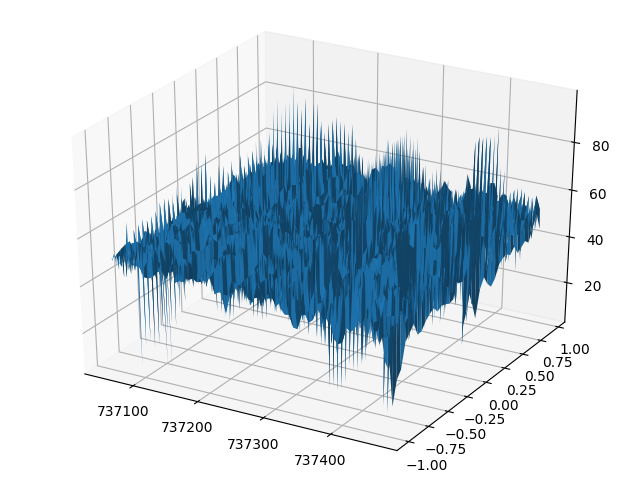

<ipython-input-12-1a768a4391b8>:12: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  ax.plot_surface(x, y, for_charting_1.values.T)


In [7]:
%matplotlib notebook
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt
from matplotlib import dates
from numpy import meshgrid

fig = plt.figure()
# fig.set_size_inches(20, 10)
ax = mplot3d.Axes3D(fig)

x, y = meshgrid(dates.date2num(for_charting_1.index), for_charting_1.columns)

ax.plot_surface(x, y, for_charting_1.values.T)
plt.show()
# plt.close()

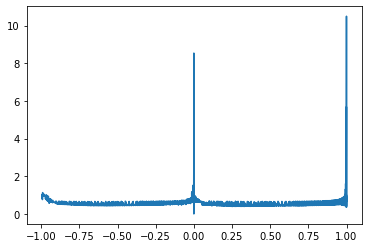

In [69]:
fig, ax = plt.subplots()

ax.plot(for_charting[for_charting.Date == for_charting.Date.iloc[-1]].delta, for_charting[for_charting.Date == for_charting.Date.iloc[-1]].impl_vol)
plt.show()
plt.close()